# Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from csv import DictReader
from matplotlib import font_manager
import string
import os
from datetime import datetime, timedelta

In [2]:
abs_dir = os.getcwd()
# Verify that the paths exist and if not, generate them
result_folder = '../../results/QALY_model/postponed_healthcare/analysis/UZG_data/'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

# Extract data

In [3]:
# location
abs_dir = os.getcwd()
rel_dir = '../../data/QALY_model/interim/postponed_healthcare/'
# baseline
file_name = 'MZG_baseline.csv'
types_dict = {'APR_MDC_key': str, 'week_number': int, 'day_number':int}
baseline = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1],dtype=types_dict).squeeze()
# raw data
file_name = 'MZG_2016_2021.csv'
types_dict = {'APR_MDC_key': str}
raw = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1,2,3],dtype=types_dict).squeeze()
raw = raw.groupby(['APR_MDC_key','date']).sum()
raw.index = raw.index.set_levels([raw.index.levels[0], pd.to_datetime(raw.index.levels[1])])
# normalised data
file_name = 'MZG_2020_2021_normalized.csv'
types_dict = {'APR_MDC_key': str}
normalised = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1],dtype=types_dict,parse_dates=True)
MDC_keys = normalised.index.get_level_values('APR_MDC_key').unique().values
# Belgian reduction data
file_name = 'hospital_stays_costs_BE.xlsx'
normalised_BE = pd.read_excel(os.path.join(abs_dir,rel_dir,file_name),sheet_name='hospital_stays',index_col=0)['Reduction (%)'].fillna(0)
# QALY data
file_name = 'hospital_yearly_QALYs.csv'
types_dict = {'MDC': str, 'yearly_QALYs_mean': float, 'yearly_QALYs_lower': float, 'yearly_QALYs_upper': float}
QALYs = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,],dtype=types_dict).fillna(0)
QALYs = QALYs.reindex(MDC_keys)

/tmp/ipykernel_2692618/926945879.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  normalised = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1],dtype=types_dict,parse_dates=True)


# Compute reductions based on data and write to excel

In [6]:
# between what dates?
start = datetime(2020,1,1)
stop = datetime(2021,1,1)

# Pre-allocate a dataframe
i = list(MDC_keys) + ['Total',]
reductions_df = pd.DataFrame(index=i, columns=['Reductions (UZG)', 'Reductions (Belgium)',
                                                'QALYs lost (UZG)', 'QALYs lost (Belgium)'])

# UZG
# ---

# reduction
strat = 100-100*raw.loc[slice(None),slice(start,stop)].groupby(by='APR_MDC_key').sum()/(7*baseline['mean'].groupby(by='APR_MDC_key').sum()*((stop-start)/timedelta(days=365)))
total = 100-100*raw.loc[slice(None),slice(start,stop)].sum()/(7*baseline['mean'].sum()*((stop-start)/timedelta(days=365)))
reductions_df['Reductions (UZG)'] = list(strat.values) + [total,]
print(total)
# QALYs stratified
total = np.array([0, 0, 0], dtype=float)
for MDC_key in MDC_keys:
    result = []
    for column_QALY in ['yearly_QALYs_mean','yearly_QALYs_lower','yearly_QALYs_upper']:
        result.append(strat.loc[MDC_key]/100*QALYs[column_QALY].loc[MDC_key]*((stop-start)/timedelta(days=365)))
    total += result
    reductions_df.loc[MDC_key, 'QALYs lost (UZG)'] = f'{result[0]:.0f} ({result[1]:.0f}; {result[2]:.0f})'
reductions_df.loc['Total', 'QALYs lost (UZG)'] = f'{total[0]:.0f} ({total[1]:.0f}; {total[2]:.0f})'

# Belgium
# -------

# reduction
reductions_df['Reductions (Belgium)'] = -normalised_BE
# QALYs stratified
strat = -normalised_BE[:-1]
total = np.array([0, 0, 0], dtype=float)
for MDC_key in MDC_keys:
    result = []
    for column_QALY in ['yearly_QALYs_mean','yearly_QALYs_lower','yearly_QALYs_upper']:
        result.append(strat.loc[MDC_key]/100*QALYs[column_QALY].loc[MDC_key]*((stop-start)/timedelta(days=365)))
    total += result
    reductions_df.loc[MDC_key, 'QALYs lost (Belgium)'] = f'{result[0]:.0f} ({result[1]:.0f}; {result[2]:.0f})'
reductions_df.loc['Total', 'QALYs lost (Belgium)'] = f'{total[0]:.0f} ({total[1]:.0f}; {total[2]:.0f})'

# Save result
# -----------

print(reductions_df)

reductions_df.index.name = 'MDC'
reductions_df.to_csv(os.path.join(abs_dir,result_folder,'reductions_QALYs_data.csv'))

10.05292649976549
       Reductions (UZG)  Reductions (Belgium)         QALYs lost (UZG)  \
00            60.050416            -18.843820     20153 (15372; 28900)   
01            17.203432             15.554716      11530 (7288; 27590)   
02            -2.540620             25.089581        -209 (-157; -319)   
03            21.989647             -2.754239      10986 (8230; 16754)   
04           -27.708863              4.160502  -23023 (-14915; -49006)   
05            13.318917            -19.874989      12823 (7622; 40907)   
06             4.079097            -16.889049        1859 (1438; 2648)   
07            -8.057103              8.801972     -2986 (-2277; -4281)   
08             9.497998             20.460706       8877 (7030; 12097)   
09            19.256064             21.025575       8580 (5795; 16517)   
10             7.106653             22.032492        1654 (1080; 3478)   
11             2.669720             10.950484           600 (469; 831)   
12            16.846

# Smooth data

In [9]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    import numpy as np
    from math import factorial
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [10]:
# filter settings
window = 3
order = 1
# copy data
baseline_smooth = pd.DataFrame(0, index=baseline.index, columns=baseline.columns)
normalised_smooth = pd.DataFrame(0, index=normalised.index, columns=normalised.columns)

for MDC_key in MDC_keys:
    for column in baseline.columns:
        baseline_smooth.loc[(MDC_key,slice(None)), column] = savitzky_golay(baseline.loc[MDC_key,slice(None)][column].values,window,order)
        normalised_smooth.loc[(MDC_key,slice(None)), column] = savitzky_golay(normalised.loc[MDC_key,slice(None)][column].values,window,order)

In [11]:
lockdowns = [(pd.to_datetime('2020-03-15'), pd.to_datetime('2020-05-07')),
                 (pd.to_datetime('2020-10-19'), pd.to_datetime('2021-02-01')),
                 (pd.to_datetime('2021-03-07'), pd.to_datetime('2021-04-18')),
                 (pd.to_datetime('2021-10-10'), pd.to_datetime('2021-12-25'))]

# Normalized data

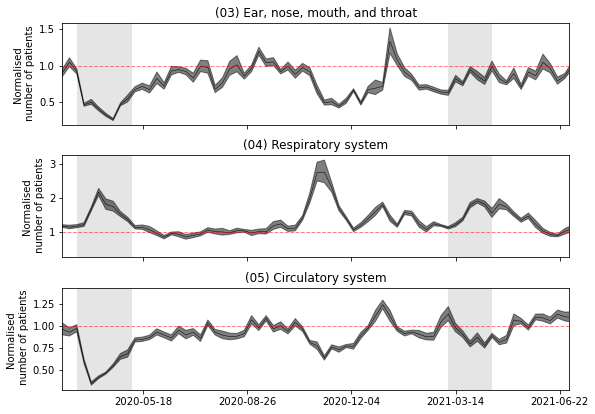

In [12]:
plot_start = datetime(2020, 3, 1)
plot_end = datetime(2021, 7, 1)
MDC_plot = ['03','04','05']
titles = ['(03) Ear, nose, mouth, and throat', '(04) Respiratory system', '(05) Circulatory system']

fig,axs=plt.subplots(len(MDC_plot),1,figsize=(8.3,0.5*11.7),sharex=True)
time = normalised.index.get_level_values('date').unique()
for idx,(MDC,title) in enumerate(zip(MDC_plot,titles)):
    # plot lockdown
    for lockdown in lockdowns:
        lockdown_start = lockdown[0]
        lockdown_end = lockdown[1]
        if lockdown_start in time:
            axs[idx].axvspan(lockdown_start,lockdown_end, facecolor='black', alpha=0.1)
    # plot data
    axs[idx].plot(time, normalised.loc[MDC]['mean'], label=title, color='black',linewidth=0.5)
    axs[idx].fill_between(time,normalised.loc[MDC]['q0.025'],normalised.loc[MDC]['q0.975'], color='black',alpha=0.5)
    # formatting
    axs[idx].axhline(y = 1, color = 'r', linestyle = 'dashed', alpha=0.5,linewidth=1)
    axs[idx].set_title(title)
    axs[idx].set_ylabel('Normalised \n number of patients',size=10)
    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=10)
    axs[idx].set_xlim([plot_start, plot_end])
fig.tight_layout()
fig.savefig(os.path.join(result_folder,'UZG_normalized.pdf'))

# UZG normalized smooth

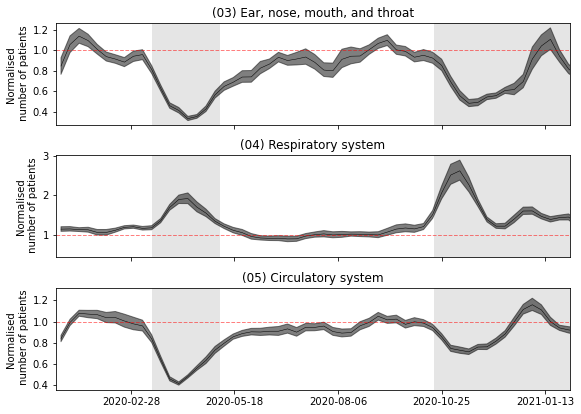

In [13]:
plot_start = datetime(2020, 1, 1)
plot_end = datetime(2021, 2, 1)
MDC_plot = ['03', '04','05']
titles = ['(03) Ear, nose, mouth, and throat', '(04) Respiratory system', '(05) Circulatory system']

fig,axs=plt.subplots(len(MDC_plot),1,figsize=(8.3,0.5*11.7),sharex=True)
time = normalised_smooth.index.get_level_values('date').unique()
for idx,(MDC,title) in enumerate(zip(MDC_plot,titles)):
    # plot lockdown
    for lockdown in lockdowns:
        lockdown_start = lockdown[0]
        lockdown_end = lockdown[1]
        axs[idx].axvspan(lockdown_start,lockdown_end, facecolor='black', alpha=0.1)
    # plot data
    axs[idx].plot(time, normalised_smooth.loc[MDC]['mean'], label=title, color='black',linewidth=0.5)
    axs[idx].fill_between(time,normalised_smooth.loc[MDC]['q0.025'],normalised_smooth.loc[MDC]['q0.975'], color='black',alpha=0.5)
    # formatting
    axs[idx].axhline(y = 1, color = 'r', linestyle = 'dashed', alpha=0.5,linewidth=1)
    axs[idx].set_title(title)
    axs[idx].set_ylabel('Normalised \n number of patients',size=10)
    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=10)
    axs[idx].set_xlim([plot_start, plot_end])
fig.tight_layout()
fig.savefig(os.path.join(result_folder,'UZG_normalized.pdf'))

# Introduction figure

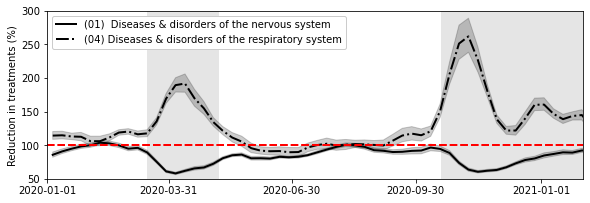

In [16]:
plot_start = datetime(2020, 1, 1)
plot_end = datetime(2021, 2, 1)
MDC_plot = ['01','04']
titles = ['(01)  Diseases & disorders of the nervous system', '(04) Diseases & disorders of the respiratory system']
colors = ['black', 'black']
linestyles = ['-', '-.']

fig,ax=plt.subplots(figsize=(8.3,0.25*11.7))
time = normalised_smooth.index.get_level_values('date').unique()
for idx,(MDC,title,color,linestyle) in enumerate(zip(MDC_plot,titles,colors,linestyles)):
    # plot lockdown
    for lockdown in lockdowns:
        lockdown_start = lockdown[0]
        lockdown_end = lockdown[1]
        ax.axvspan(lockdown_start,lockdown_end, facecolor='black', alpha=0.05)
    # plot data
    ax.plot(time, 100*normalised_smooth.loc[MDC]['mean'], label=title, color=color, linewidth=2, linestyle=linestyle)
    ax.fill_between(time, 100*normalised_smooth.loc[MDC]['q0.025'], 100*normalised_smooth.loc[MDC]['q0.975'], color='black', alpha=0.20)
    
    # formatting
    ax.axhline(y = 100, color = 'r', linestyle = 'dashed', alpha=1, linewidth=2)
    ax.set_ylabel('Reduction in treatments (%)',size=10)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_xticks([datetime(2020,1,1), datetime(2020,3,31),datetime(2020,6,30),datetime(2020,9,30),
                   datetime(2021,1,1),datetime(2021,3,31),datetime(2021,6,30)])
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='x', which='major', rotation=0)
    ax.set_xlim([plot_start, plot_end])
    ax.set_ylim([50,300])
    ax.legend(framealpha=1, fontsize=10)
fig.tight_layout()
fig.savefig(os.path.join(result_folder,'UZG_normalized.pdf'))

# all MDCs

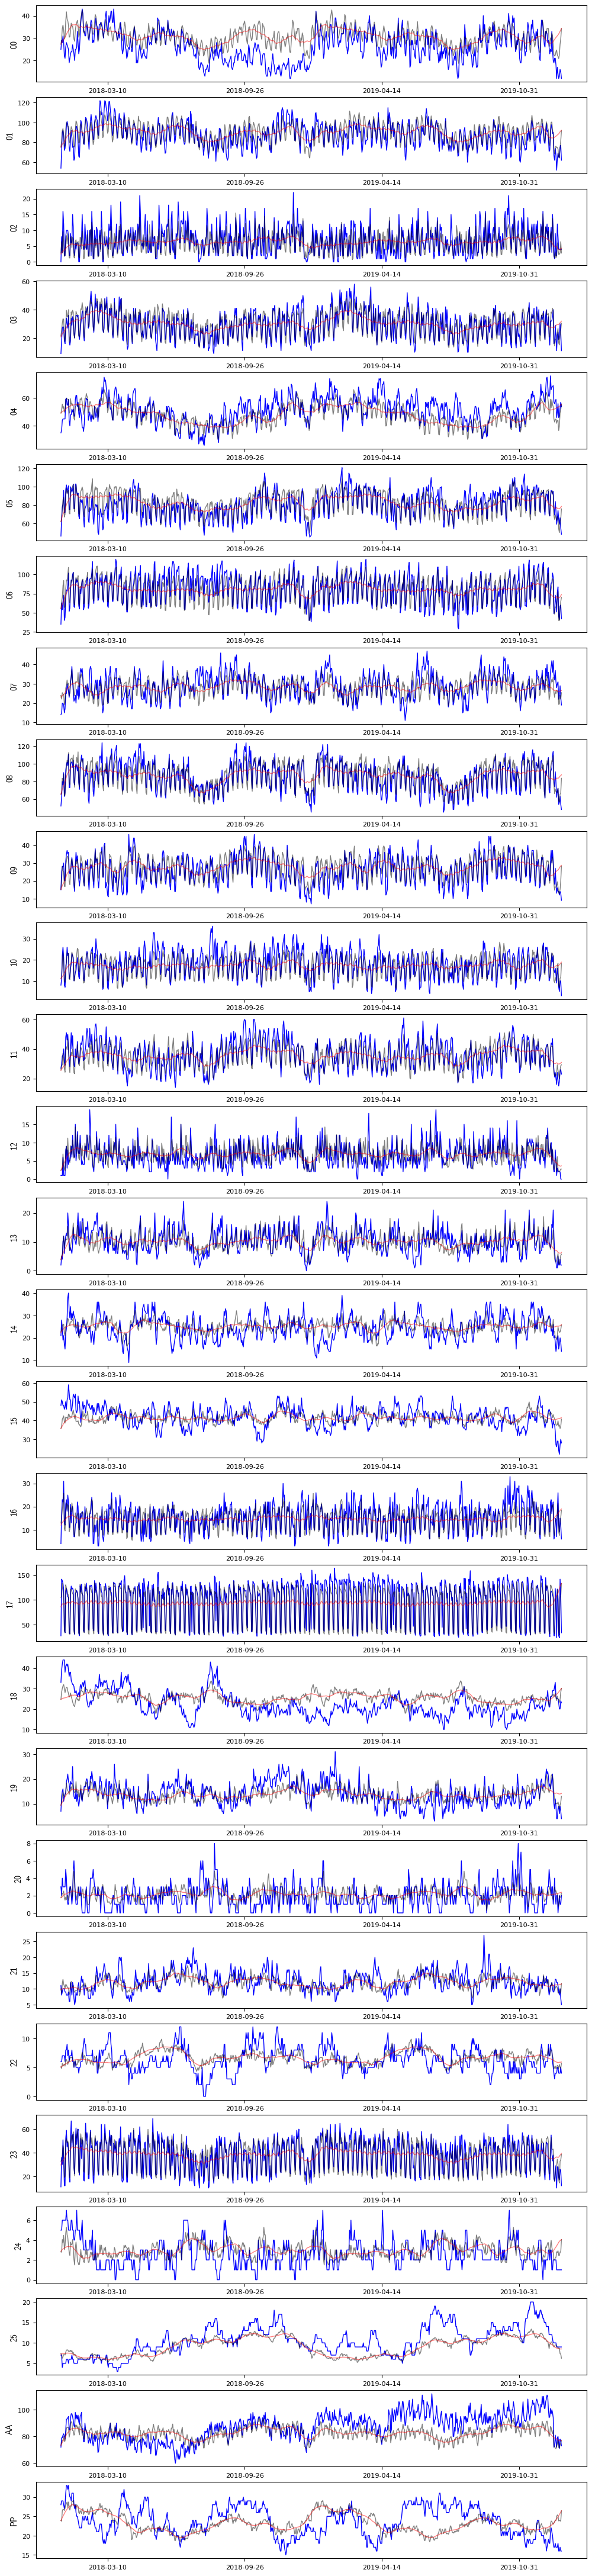

In [25]:
plot_start = pd.to_datetime('2018-01-01')
plot_end = pd.to_datetime('2020-01-01')
plot_time = pd.date_range(plot_start,plot_end)
MDC_plot = MDC_keys

multi_index = pd.MultiIndex.from_product([MDC_plot,plot_time])
baseline_in_date_form = pd.Series(index=multi_index,dtype="float")
for idx,(disease,date) in enumerate(multi_index):
    baseline_in_date_form[idx] = baseline_mean.loc[(disease,date.isocalendar().week,date.isocalendar().weekday)]

fig,axs = plt.subplots(len(MDC_plot),1,figsize=(12,len(MDC_plot)*2))
for idx,disease in enumerate(MDC_plot):
    hospitalizations_plot = hospitalizations.loc[(disease,plot_time)]
    baseline_plot = baseline_in_date_form.loc[(disease,plot_time)]
    baseline_smooth = savitzky_golay(baseline_plot,51,3)

    axs[idx].plot(plot_time,hospitalizations_plot,linewidth=1,label=MDC_dict[disease],color='blue')
    axs[idx].plot(plot_time,baseline_plot,linewidth=1,label=MDC_dict[disease],color='black',alpha=0.5)
    axs[idx].plot(plot_time,baseline_smooth,linewidth=1,label=MDC_dict[disease],color='red',alpha=0.5)

    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=8)
    axs[idx].tick_params(axis='both', which='minor', labelsize=8)
    axs[idx].set_ylabel(disease,font=label_font)

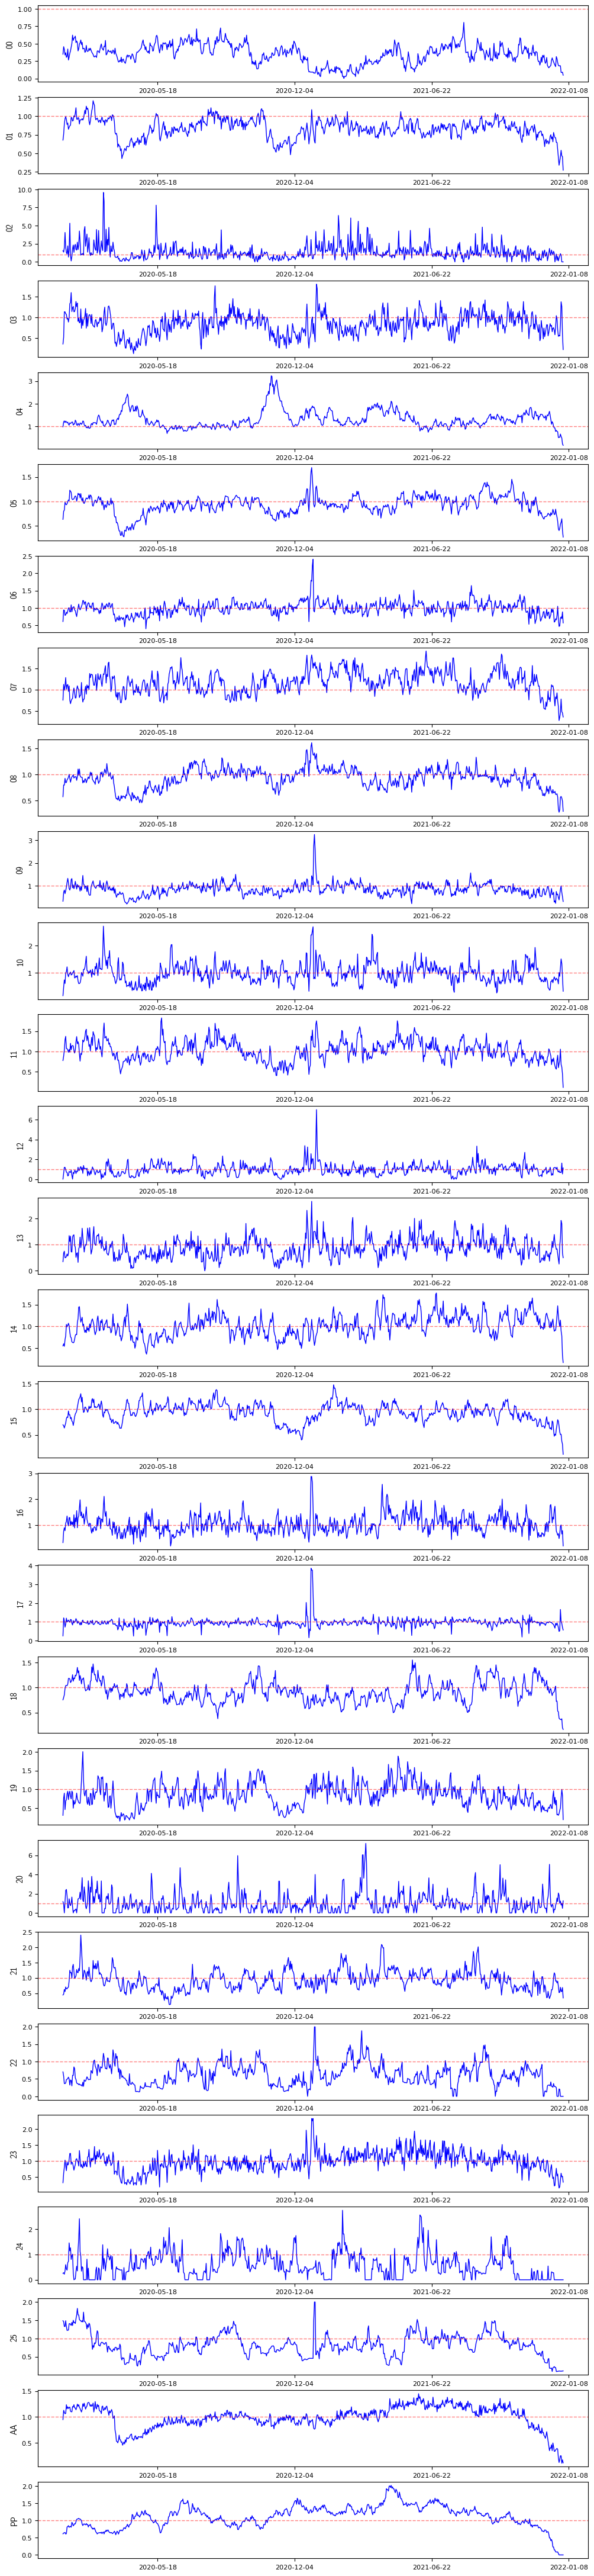

In [26]:
plot_start = pd.to_datetime('2020-01-01')
plot_end = pd.to_datetime('2021-12-31')
plot_time = pd.date_range(plot_start,plot_end)
MDC_plot = MDC_keys

fig,axs = plt.subplots(len(MDC_plot),1,figsize=(12,len(MDC_plot)*2))
for idx,disease in enumerate(MDC_plot):
    #out_plot = pd.DataFrame(out_plot).ewm(7).mean()
    mean = hospitalizations_normalized.loc[(disease,plot_time)]
    #lower = hospitalizations_normalized_quantiles['q0.025'].loc[(disease,plot_time)]
    #upper = hospitalizations_normalized_quantiles['q0.975'].loc[(disease,plot_time)]
    axs[idx].plot(plot_time,mean,linewidth=1,label=MDC_dict[disease],color='blue')
    #as[idx]x.fill_between(plot_time,lower,upper, color='black',alpha=0.5)
    axs[idx].axhline(y = 1, color = 'r', linestyle = 'dashed', alpha=0.5,linewidth=1)
    #as[idx]x.set_title(disease,font=label_font)
    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=8)
    axs[idx].tick_params(axis='both', which='minor', labelsize=8)
    axs[idx].set_ylabel(disease,font=label_font)